# Setup

In [ ]:
!pip install torchaudio librosa

In [2]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import math
from IPython.display import Audio, display
from tqdm import tqdm

print(torch.__version__)
print(torchaudio.__version__)

ModuleNotFoundError: ignored

# Feature Extraction

In [ ]:
# Utility functions from torchaudio tutorial
# https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

metadata AudioMetaData(sample_rate=16000, num_frames=23960, num_channels=1, bits_per_sample=16, encoding=PCM_S)
size torch.Size([1, 23960])


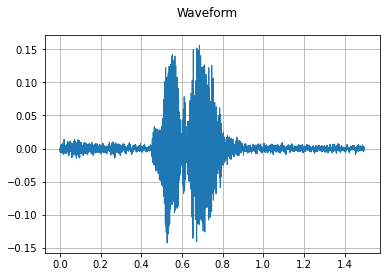

torch.Size([1, 224, 47])


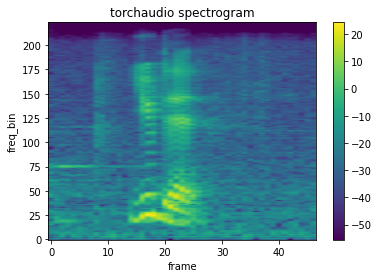

tensor(5.6145)
tensor(-17.1571)


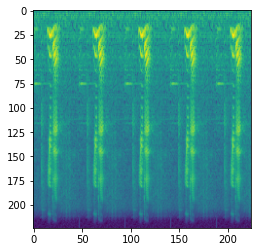

In [ ]:
# test 1

def get_waveform(file_id):
    DATA_DIR = '/content/drive/MyDrive/CMU/Fall 2021/SRU/SRU Project/18-781-Project/emotion/data/iemocap'
    filename = f'{DATA_DIR}/wav/{file_id[:-5]}/{file_id}.wav'
    return torchaudio.load(filename)

def get_metadata(file_id):
    DATA_DIR = '/content/drive/MyDrive/CMU/Fall 2021/SRU/SRU Project/18-781-Project/emotion/data/iemocap'
    filename = f'{DATA_DIR}/wav/{file_id[:-5]}/{file_id}.wav'
    return torchaudio.info(filename)

# file_id = 'Ses05M_script02_1_M030' # max length utterance
# file_id = 'Ses03M_impro07_M007' # min length utterance
file_id = 'Ses01F_impro01_F003'
waveform, fs = get_waveform(file_id)
metadata = get_metadata(file_id)

print('metadata', metadata)
print('size', waveform.size())
plot_waveform(waveform, fs)
play_audio(waveform, fs)

transforms = torch.nn.Sequential(
    T.MelSpectrogram(n_fft=1024, n_mels=224)
)

spec = transforms(waveform)
log_spec = torch.log(spec)
print(spec.shape)
time_shape = spec.shape[2]
n_copies = math.floor(224 / time_shape)
remainder = 224 % time_shape

plot_spectrogram(spec[0], title='torchaudio spectrogram')

# should we concatenate like this? other options are to stretch, just add silence, or reduce frequency resolution (probably bad)
image = torch.cat([log_spec] * n_copies + [log_spec[:,:,:remainder]], dim=2)

assert image.shape[1] == 224 and image.shape[2] == 224
plt.imshow(image[0])
plt.imsave('/content/test.png', image[0])
print(torch.max(image))
print(torch.min(image))

## Stats
Spectrogram v1: min -31.1674, max 11.4212

# Data Exploration

In [11]:
from collections import Counter
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/18-781-Project/emotion/data/iemocap/labels.csv')
# print(df.head())
# print(df.tail())

# remove extra labels
# for l in ['xxx', 'fru', 'sur', 'fea', 'oth', 'dis']:
#     df = df[df.emotion_label != l]
# df.loc[df.emotion_label == 'exc', 'emotion_label'] = 'hap'


session_counts = Counter()
label_counts = Counter()
total_count = 0

sessions = [i[:5] for i in df['file_id']]
session_counts.update(sessions)
print('sessions:')
for key in sorted(session_counts.keys()): print(f'{key}: {session_counts[key]}')

labels = [i for i in df['emotion_label']]
label_counts.update(labels)
print('\nlabels:')
print(sorted(((v, k) for k, v in label_counts.items()), reverse=True))


for i, row in df.iterrows():
    total_count += 1

print()
print('Train: ', sum([session_counts[f'Ses0{i}'] for i in range(1, 5)]))
print('Test: ', session_counts['Ses05'])
print('Total: ', total_count)

# lengths = {}

# # for file_id in tqdm(list(df['file_id'])):
# #     metadata = get_metadata(file_id)
# #     lengths[file_id] = metadata.num_frames

# print(lengths)
# max length: Ses05M_script02_1_M030
# min length: Ses03M_impro07_M007

########

sessions:
Ses01: 1819
Ses02: 1811
Ses03: 2136
Ses04: 2103
Ses05: 2170

labels:
[(2507, 'xxx'), (1849, 'fru'), (1708, 'neu'), (1103, 'ang'), (1084, 'sad'), (1041, 'exc'), (595, 'hap'), (107, 'sur'), (40, 'fea'), (3, 'oth'), (2, 'dis')]

Train:  7869
Test:  2170
Total:  10039


In [12]:
# gdrive sanity check
from skimage import io
io.imread('/content/drive/MyDrive/18-781-Project/emotion/data/iemocap/spectrogram_v1/Ses03M_impro08b_F021.png')

array([[[ 43, 116, 142, 255],
        [ 44, 113, 142, 255],
        [ 36, 134, 141, 255],
        ...,
        [ 39, 126, 142, 255],
        [ 40, 122, 142, 255],
        [ 44, 112, 142, 255]],

       [[ 30, 155, 137, 255],
        [ 30, 152, 138, 255],
        [ 39, 173, 128, 255],
        ...,
        [ 33, 166, 133, 255],
        [ 31, 161, 135, 255],
        [ 30, 152, 138, 255]],

       [[ 38, 127, 142, 255],
        [ 31, 162, 134, 255],
        [ 30, 155, 137, 255],
        ...,
        [ 35, 168, 131, 255],
        [ 31, 161, 135, 255],
        [ 30, 151, 138, 255]],

       ...,

       [[ 53,  93, 140, 255],
        [ 72,  30, 112, 255],
        [ 71,  37, 117, 255],
        ...,
        [ 68,   1,  84, 255],
        [ 71,  43, 122, 255],
        [ 72,  34, 115, 255]],

       [[ 54,  91, 140, 255],
        [ 71,  38, 118, 255],
        [ 71,  18, 101, 255],
        ...,
        [ 70,   9,  92, 255],
        [ 71,  40, 120, 255],
        [ 72,  29, 111, 255]],

       [[ 54

In [18]:
!cd /content/drive/MyDrive/18-781-Project/emotion/data/iemocap/spectrogram_v1; ls | wc -l
!find /content/drive/MyDrive/18-781-Project/emotion/data/iemocap/wav -type f | grep wav | wc -l

10039
10043
